In [1]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

In [2]:
def ler(x):

    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [3]:
#Lemos o dataset e criamos uma lista com todos os valores
with open("digits.base64.json","r") as f:
    digits = map(ler, f.readlines())
digits=list(digits)

In [4]:
#Definimos uma função que transforma os vetores com os pixeis em uma imagem
#com o digito
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))

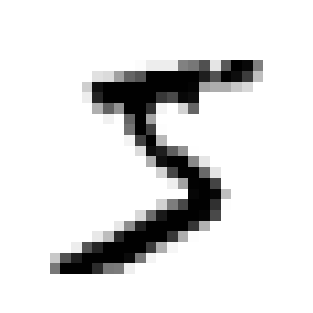

In [5]:
display_digit(digits[0])

In [6]:
#Criamos uma nova lista que armazenará apenas a informação dos pixeis
#de cada dígito
new_digits=[]
cont=0
while cont<len(digits):
    new_digits.append(digits[cont][1])
    cont+=1

In [7]:
#Usamos o KMeans do sklearn para descobrir as clusters
n=10
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
#Criamos uma lista com o index da cluster à qual cada dígito pertence
#Criamos também uma lista com os centros de cada cluster
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
clus

array([7, 4, 3, ..., 7, 5, 9])

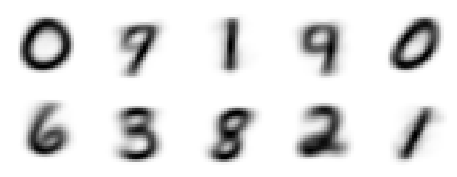

In [9]:
#Encontramos os pontos mais próximos dos centros de cada cluster e plotamos eles,
#para que seja possível ter uma ideia da forma dos números que estão em cada
#cluster. Idealmente, cada cluster só conteria dígitos que são os mesmos que seus
#centros
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = centers.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [10]:
def acha_nome(i):
    valores=[0,0,0,0,0,0,0,0,0,0]
    cont=0
    while cont<len(digits):
        if clus[cont]==i:
            valores[digits[cont][0]]=valores[digits[cont][0]]+1
        cont=cont+1
    m=max(valores)
    cont=0
    while cont<len(valores):
        if m==valores[cont]:
            return cont
        cont=cont+1
            

In [11]:
#Utilizamos a função para encontrar o dígito mais frequente e "nomeamos" a cluster
#por esse dígito. O index na lista nomes representa o index da cluster e o valor
#a ele associado é o nome da cluster.
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
nomes

array([0, 7, 1, 4, 0, 6, 3, 8, 2, 1])

In [12]:
#Cria lista ground truth, que possúi o real valor de cada dígito
gt=[]
clus_nome=[]
cont=0
while cont<len(digits):
    gt.append(digits[cont][0])
    clus_nome.append(nomes[clus[cont]])
    cont=cont+1

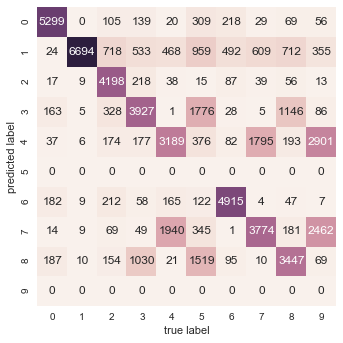

In [13]:
#Criamos uma confusion matrix, que nos mostra os erros e acertos das clusters
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [14]:
#Escrevemos, agora, um código que nos dirá a porcentamge dos acertos
def taxa(mat):
    acertos=0
    cont=0
    while cont<10:
        acertos += mat[cont][cont]
        cont += 1
    taxa = acertos/60000
    return taxa

In [30]:
taxa(mat)

0.59071666666666667

Vemos, assim, que nosso programa já é capaz de agrupar os dígitos na maior parte das vezes. Ainda podemos, no entanto, melhorar bastante sua performance. Olhando para a confusion matrix, é fácil perceber um grave problema: cincos e noves nunca foram corretamente classificados. Olhando para a lista com os "nomes" dos clusters e para as imagens dos centros, encontramos o motivo: nenhuma cluster foi classificada como "5" ou como "9", apesar de dois dos centros serem noves. As clusters desses centros receberam os nomes de 7 e 4, que de fato se assemelham à forma dos noves da imagem. Também vemos que dois dos centros são uns e outros dois são zeros. Isso ocorre porque existem mais do que uma forma de desenhar certos dígitos. Nossa decisão inicial de aplicar o k-means com apenas 10 clusters acabou comprometendo a performance do programa.

Fazemos, a seguir, um estudo de performance em relação ao número de clusters:

In [40]:
n=10
perf=[]
while n<31:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits):
        gt.append(digits[cont][0])
        clus_nome.append(nomes[clus[cont]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf.append(taxa(mat))
    n+=1
perf

[0.59079999999999999,
 0.59184999999999999,
 0.60575000000000001,
 0.62065000000000003,
 0.65521666666666667,
 0.67656666666666665,
 0.69255,
 0.69591666666666663,
 0.70568333333333333,
 0.72283333333333333,
 0.70846666666666669,
 0.72281666666666666,
 0.71686666666666665,
 0.72761666666666669,
 0.73973333333333335,
 0.73886666666666667,
 0.74890000000000001,
 0.74375000000000002,
 0.74106666666666665,
 0.75860000000000005,
 0.75006666666666666]

In [42]:
perf2=[]
n=31
while n<41:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits):
        gt.append(digits[cont][0])
        clus_nome.append(nomes[clus[cont]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf2.append(taxa(mat))
    n+=1
perf2

[0.75270000000000004,
 0.7547166666666667,
 0.75885000000000002,
 0.75596666666666668,
 0.78021666666666667,
 0.76985000000000003,
 0.77741666666666664,
 0.77793333333333337,
 0.79254999999999998,
 0.79271666666666663]

In [47]:
perf4=[]
n=41
while n<46:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits):
        gt.append(digits[cont][0])
        clus_nome.append(nomes[clus[cont]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf4.append(taxa(mat))
    n+=1
perf4

[0.79111666666666669,
 0.79595000000000005,
 0.80098333333333338,
 0.79286666666666672,
 0.80505000000000004]

In [53]:
n=100
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
gt=[]
clus_nome=[]
cont=0
while cont<len(digits):
    gt.append(digits[cont][0])
    clus_nome.append(nomes[clus[cont]])
    cont=cont+1
mat = confusion_matrix(gt, clus_nome)
taxa100=taxa(mat)
print(taxa100)

0.876833333333


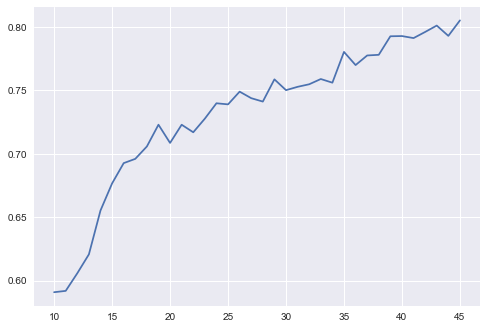

In [50]:
perf3=perf+perf2
perf3=perf3+perf4
plt.plot(np.arange(10,46),perf3)
plt.show()

In [ ]:
Nosso estudo nos mostra que à medida que aumentamos o número de clusters, a 
performance melhora, sem limite aparente. Ao considerar 100 clusters para o
algorítmo, a performance foi bem superior, chegando a quase 88%

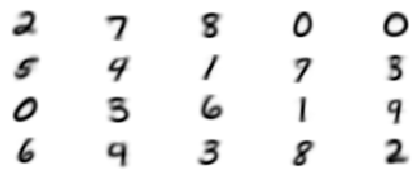

In [52]:
n=20
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(4, 5, figsize=(8, 3))
centers = centers.reshape(20, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

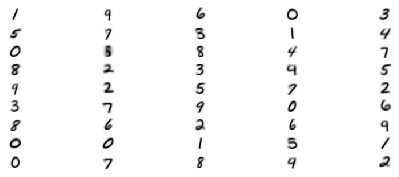

In [54]:
n=45
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(9, 5, figsize=(8, 3))
centers = centers.reshape(45, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Vemos aqui, para 45 clusters, os centros. De acordo com o que esperávamos, os centros parecem tomar a forma de jeitos comuns de se escrever cada dígito. Parece que à medida que tomamos mais e mais clusters para rodar o algorítmo, obtemos mais centros que correspondem a uma forma específica de se escrever cada dígito, assim aumentando a chance daquele dígito ser corretamente classificado.

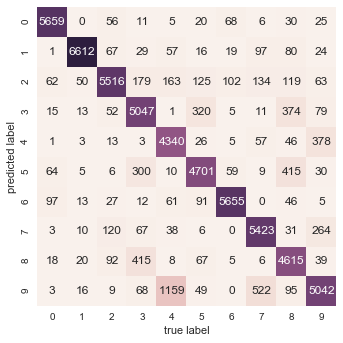

In [55]:
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [25]:
# print(*clus, sep='\n')